In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

import numpy as np
import itertools
import re

import seaborn as sns
from matplotlib import pyplot as plt
from upsetplot import UpSet, from_contents


rd = pd.read_excel('./Resources/phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']


## Orphanet mapping

In [27]:
map = pd.read_pickle('./OT/Final/diseases_cleaned.pkl').dropna()
map['code'] = map['code'].astype(str)
map = map.loc[map['phecode'].isin(rd.loc[rd['Type'] != 'Common']['phecode'])]
map = map.loc[map['id'].str.contains('Orphanet')]
map = map[['id','name','phecode']].drop_duplicates()

p1 = pd.read_csv('./RareDisease/Resources/phecodeX_unrolled_ICD_CM.csv')
p2 = pd.read_csv('./RareDisease/Resources/phecodeX_unrolled_ICD_WHO.csv')
comb = pd.concat([p1,p2])
comb = comb.rename({'ICD':'code'},axis=1)
comb.loc[comb['vocabulary_id'].str.contains('ICD9'), 'icd_type'] = 'ICD9'
comb.loc[comb['vocabulary_id'].str.contains('ICD10'), 'icd_type'] = 'ICD10'
comb = comb[['phecode','code']]

umls = pd.read_pickle('./Drugs/Resources/umls.pkl')[[0,11,13,14]]

umls_icd = umls.loc[umls[11].str.contains('ICD9|ICD10')]
umls_icd = umls_icd.merge(comb, left_on=13, right_on='code')[[0,'phecode']].drop_duplicates()
umls_icd = umls_icd.loc[umls_icd['phecode'].isin(rd.loc[rd['Type'] != 'Common']['phecode'])]

umls_hpo = umls.loc[umls[11] == 'HPO']
umls_hpo[13] = umls_hpo[13].str.replace('HP:','').str.lstrip('0').astype(int)
hp = pd.read_pickle('./OT/HPO/hpo_phecodex_map.pkl')[['phecode','id']]
hp['code'] = hp['id'].str.replace('HP_', '').str.lstrip('0').astype(int)
hp = hp[['code','phecode']]
umls_hpo = umls_hpo.merge(hp, left_on=13, right_on='code')[[0,'phecode']].drop_duplicates()
umls_hpo = umls_hpo.loc[umls_hpo['phecode'].isin(rd.loc[rd['Type'] != 'Common']['phecode'])]

umls_orpha = umls.loc[umls[11] == 'ORPHANET']
umls_orpha[13] = 'Orphanet_' + umls_orpha[13].astype(str)
umls_orpha_icd = umls_orpha.merge(umls_icd, on=0)[[13,'phecode',14]].set_axis(['id','phecode','name'],axis=1)
umls_orpha_hpo = umls_orpha.merge(umls_hpo, on=0)[[13,'phecode',14]].set_axis(['id','phecode','name'],axis=1)

comb = pd.concat([umls_orpha_icd,umls_orpha_hpo,map]).drop_duplicates(['id','phecode'])
comb = comb.merge(rd[['phecode','phecode_string']])
comb['id'] = comb['id'].str.split('_').str[1].astype(int)
comb = comb[['phecode','phecode_string','id','name']].sort_values(['phecode','id'])
comb = comb.set_axis(['Phecode','Phecode string','Orphanet ID','Orphanet name'],axis=1)
comb = comb.groupby(['Phecode','Phecode string','Orphanet ID']).first()
comb.to_excel('./Results/orphanet.xlsx')


## Minikel

In [2]:
map = pd.read_pickle('./OT/Final/diseases_cleaned.pkl').dropna()
map['code'] = map['code'].astype(str)
map = map.loc[map['terminology'] == 'MeSH']
map = map[['code','phecode']]

p1 = pd.read_csv('./RareDisease/Resources/phecodeX_unrolled_ICD_CM.csv')
p2 = pd.read_csv('./RareDisease/Resources/phecodeX_unrolled_ICD_WHO.csv')
comb = pd.concat([p1,p2])
comb = comb.rename({'ICD':'code'},axis=1)
comb.loc[comb['vocabulary_id'].str.contains('ICD9'), 'icd_type'] = 'ICD9'
comb.loc[comb['vocabulary_id'].str.contains('ICD10'), 'icd_type'] = 'ICD10'
comb = comb[['phecode','code']]

umls = pd.read_pickle('./Drugs/Resources/umls.pkl')[[0,11,13]]

umls_icd = umls.loc[umls[11].str.contains('ICD9|ICD10')]
umls_icd = umls_icd.merge(comb, left_on=13, right_on='code')[[0,'phecode']].drop_duplicates()

umls_hpo = umls.loc[umls[11] == 'HPO']
umls_hpo[13] = umls_hpo[13].str.replace('HP:','').str.lstrip('0').astype(int)
hp = pd.read_pickle('./OT/HPO/hpo_phecodex_map.pkl')[['phecode','id']]
hp['code'] = hp['id'].str.replace('HP_', '').str.lstrip('0').astype(int)
hp = hp[['code','phecode']]
umls_hpo = umls_hpo.merge(hp, left_on=13, right_on='code')[[0,'phecode']].drop_duplicates()

umls_msh = umls.loc[umls[11].str.contains('MSH')]
umls_msh_icd = umls_msh.merge(umls_icd, on=0)
umls_msh_icd = umls_msh_icd[[13,'phecode']].rename({13:'code'},axis=1).drop_duplicates()
umls_msh_hpo = umls_msh.merge(umls_hpo, on=0)
umls_msh_hpo = umls_msh_hpo[[13,'phecode']].rename({13:'code'},axis=1).drop_duplicates()

map = pd.concat([map,umls_msh_icd,umls_hpo]).drop_duplicates()
umls = 0

md = pd.read_excel('./RareDrug/Resources/minikel_drugs.xlsx')
md = md.rename({'indication_mesh_id':'code'},axis=1)
md = md.merge(map, on='code')
md = md.rename({'target':'gene','combined_max_phase':'phase'},axis=1)
md.to_pickle('./RareDrug/Resources/minikel_drugs_cleaned.pkl')
md = 0


## Targets

In [4]:
# https://github.com/opentargets/issues/issues/533

dir = './Drugs'
dc = pd.read_pickle(dir+'/SIDER/drug_conv.pkl')
dc = dc.rename({'CHEMBL':'chembl_id'},axis=1)
dc['name'] = dc['name'].str.lower()

#####

moa = pd.read_pickle('./OT/Raw/mechanismOfAction.pkl')
moa['moa'] = 'Other'
moa.loc[moa['actionType'].isin(['INHIBITOR', 'ANTAGONIST', 'BLOCKER', 'NEGATIVE ALLOSTERIC MODULATOR',
                                'ANTISENSE INHIBITOR', 'RELEASING AGENT', 'ALLOSTERIC ANTAGONIST', 'INVERSE AGONIST',
                                'NEGATIVE MODULATOR', 'DEGRADER']),'moa'] = 'Negative modulator'
moa.loc[moa['actionType'].isin(['AGONIST', 'OPENER', 'ACTIVATOR', 
                                'POSITIVE ALLOSTERIC MODULATOR', 'POSITIVE MODULATOR', 
                                'PARTIAL AGONIST']),'moa'] = 'Positive modulator'
moa = moa[['moa','chemblIds','targets']]
moa = moa.explode('chemblIds')
moa = moa.explode('targets')
moa = moa.merge(pd.read_pickle('./OT/Raw/targets.pkl')[['id','approvedSymbol']].rename({'id':'targets'},axis=1))
moa = moa.rename({'chemblIds':'chembl_id','approvedSymbol':'gene'},axis=1).drop_duplicates()
moa = moa.merge(dc[['chembl_id','CID']].dropna(), on='chembl_id', how='left')

#####

ct = pd.read_csv('./ChEMBL/chembl_34_drug_targets.csv')
ct = ct.loc[(ct['syn_type'] == 'GENE_SYMBOL') & (ct['organism'] == 'Homo sapiens')]
ct['moa'] = 'Other'
ct.loc[ct['action_type'].isin(['INHIBITOR', 'ANTAGONIST', 'BLOCKER', 'NEGATIVE ALLOSTERIC MODULATOR',
                                'ANTISENSE INHIBITOR', 'RELEASING AGENT', 'ALLOSTERIC ANTAGONIST', 'INVERSE AGONIST',
                                'NEGATIVE MODULATOR', 'DEGRADER']),'moa'] = 'Negative modulator'
ct.loc[ct['action_type'].isin(['AGONIST', 'OPENER', 'ACTIVATOR', 
                                'POSITIVE ALLOSTERIC MODULATOR', 'POSITIVE MODULATOR', 
                                'PARTIAL AGONIST']),'moa'] = 'Positive modulator'
ct = ct[['chembl_id','moa','component_synonym','pref_name']].rename({'component_synonym':'gene','pref_name':'name'},axis=1)
ct['name'] = ct['name'].str.lower()
ct = pd.concat([ct.merge(dc[['chembl_id','CID']].dropna(), how='left'),ct.merge(dc[['name','CID']].dropna(), how='left')]).drop_duplicates()

#####

dir = './Drugs'

ndr = pd.read_excel(dir+'/SIDER/Targets/ndr_list.xlsx')
ndr = ndr.loc[ndr['ORGANISM'] == 'Homo sapiens']
ndr['moa'] = 'Other'
ndr.loc[ndr['MECHANISM_OF_ACTION'].str.contains('inhibitor|antagonist|blocker|negative allo|antisense|releasing|inverse agonist|negative modulator|degrader', na=False), 'moa'] = 'Negative modulator'
ndr.loc[(~ndr['MECHANISM_OF_ACTION'].str.contains('inverse|antagonist', na=False)) & (ndr['MECHANISM_OF_ACTION'].str.contains('agonist', na=False)), 'moa'] = 'Positive modulator'
ndr.loc[ndr['MECHANISM_OF_ACTION'].str.contains('opener|activator|positive allo|positive modulator|partial agonist', na=False), 'moa'] = 'Positive modulator'

hgnc = pd.read_csv(dir+'/Resources/hgnc_genes.txt', sep='\t')
hgnc = hgnc.sort_values(['HGNC ID','Status']).drop_duplicates('HGNC ID')
hgnc = hgnc[['HGNC ID','Approved symbol']].rename({'Approved symbol':'Gene'},axis=1)
conv = pd.read_csv(dir+'/SIDER/Targets/ndr_hgnc.tsv', sep='\t').set_axis(['ACCESSION','HGNC ID'],axis=1)
conv = conv.merge(hgnc)[['ACCESSION', 'Gene']]

ndr = ndr.merge(conv)
ndr = ndr[['TARGET_CHEMBL_ID','moa','Gene']].set_axis(['chembl_id','moa','gene'],axis=1)
ndr = ndr.merge(dc[['chembl_id','CID']].dropna(), how='left')

#####

dpa = pd.read_csv(dir+'/SIDER/Targets/drugbank_pharm_active.csv')
dpa = dpa.loc[dpa['Species'] == 'Humans']
dpa = dpa.merge(hgnc)
dpa = dpa.assign(Drugbank=dpa['Drug IDs'].str.split(';')).explode('Drugbank')
dpa = dpa[['Drugbank','Gene','UniProt ID','Species']].drop_duplicates()
dpa = dpa[['Drugbank','Gene']].merge(dc[['Drugbank','CID','chembl_id']].dropna())[['Drugbank','CID','chembl_id','Gene']].set_axis(['Drugbank','CID','chembl_id','Gene'],axis=1).drop_duplicates()
db_moa = pd.read_pickle(dir+'/SIDER/Targets/drugbank_moa.pkl')
dpa = dpa.merge(db_moa[['Drugbank','Action']])
dpa['Action'] = dpa['Action'].str.upper()
dpa['moa'] = 'Other'
dpa.loc[dpa['Action'].isin(['INHIBITOR', 'ANTAGONIST', 'BLOCKER', 'NEGATIVE ALLOSTERIC MODULATOR',
                                'ANTISENSE INHIBITOR', 'RELEASING AGENT', 'ALLOSTERIC ANTAGONIST', 'INVERSE AGONIST',
                                'NEGATIVE MODULATOR', 'DEGRADER']),'moa'] = 'Negative modulator'
dpa.loc[dpa['Action'].isin(['AGONIST', 'OPENER', 'ACTIVATOR', 
                                'POSITIVE ALLOSTERIC MODULATOR', 'POSITIVE MODULATOR', 
                                'PARTIAL AGONIST']),'moa'] = 'Positive modulator'
dpa = dpa[['Drugbank','chembl_id','moa','Gene','CID']].set_axis(['drugbank_id','chembl_id','moa','gene','CID'],axis=1)

#####

targets = pd.concat([moa,ct,ndr,dpa])
targets.drop('targets',axis=1).drop_duplicates().to_pickle('./Resources/targets_with_names.pkl')
targets = targets.drop(['targets','name'],axis=1).drop_duplicates()
targets.to_pickle('./Resources/targets.pkl')
targets = 0
moa = 0
ct = 0
ndr = 0
dpa = 0


In [4]:
def clean_m_name(m_name):
    modifiers = ['sulfate', 'sodium', 'hydrochloride', 'hydroxide', 'phosphate', 'tablet', 'injection',
                 'acetate', 'citrate', 'bromide', 'iodide', 'carbonate', 'chloride', 
                 'silicate', 'liposome', 'ultramicrosize', 'isopropyl', 'alcohol',
                 'injectable', 'product', 'powder', 'prefilled', 'syringe', 'tosylate',
                 'mesylate', 'mesylates', 'tartrate', 'decanoate', 'lauroxil', 'magnesium', 'calcium',
                 'dipotassium', 'potassium', 'diproprionate', 'palmitate', 'succinate', 'pamoate', 'valerate',
                 'aspartate', 'strontium', 'epolamine', 'polyethylene', 'proprionate',
                 'maleate','besylate','fumarate','dihydrate','malate','monohydrate',
                 'mertansine','acetonide','lactate','benzoate','propionate','purified',
                 'human','recombinant','synthetic','semisynthetic']
    return ' '.join(word for word in m_name.split() if not any(modifier in word.lower() for modifier in modifiers))

def clean_m_name_full(m_name):
    modifiers = ['hr', 'ml', 'mcg', 'pegol', 'alfa', 'susp', 'cal', 'oxide', 'oral', 'zinc', 'pork', 'beef', 'glycol', '%', 'nacl']
    pattern = r'\b(?:' + '|'.join(modifiers) + r')\b'
    return re.sub(pattern, '', m_name, flags=re.IGNORECASE).strip()

tn = pd.read_pickle('./Resources/targets_with_names.pkl')
tn['name'] = tn['name'].astype(str).str.lower().apply(clean_m_name).apply(clean_m_name_full)
tn.loc[tn['name'] == 'nan', 'name'] = np.nan
tn.loc[tn['name'] == ' ', 'name'] = np.nan
tn.loc[tn['name'].str.len() < 2, 'name'] = np.nan

dn = pd.read_csv('./MSDW/Conversion/drugbank_links.csv')[['DrugBank ID','Name']]
cn = pd.read_csv('./RareDrug/ChEMBL/chembl_34_drug_targets.csv')[['chembl_id','pref_name']]
cn2 = pd.read_csv('./RareDrug/ChEMBL/chembl_missing_names.tsv', sep='\t')[['ChEMBL ID','Name']].set_axis(['chembl_id','dc_name'],axis=1)
dn = dn.set_axis(['drugbank_id','dc_name'],axis=1)
cn = cn.set_axis(['chembl_id','dc_name'],axis=1)
dc = pd.concat([dn,cn,cn2]).drop_duplicates()
dc['dc_name'] = dc['dc_name'].astype(str).str.lower().apply(clean_m_name).apply(clean_m_name_full)

tn_a = tn.loc[tn['name'].notna()].rename({'name':'dc_name'},axis=1)
tn_b = tn.loc[tn['name'].isna()].drop('name',axis=1)
tn_c = tn_b.merge(dc[['drugbank_id','dc_name']].dropna(),how='left')
tn_c = tn_c.loc[tn_c['dc_name'].notna()]
tn_d = tn_b.merge(dc[['chembl_id','dc_name']].dropna(),how='left')
tn_d = tn_d.loc[tn_d['dc_name'].notna()]

tn_all = pd.concat([tn_a,tn_c,tn_d]).drop_duplicates()
tn_all = tn_all.loc[tn_all['dc_name'].str.len() > 1]
tn_all = tn_all[['moa','gene','chembl_id','dc_name']].drop_duplicates()

ct = pd.read_csv('./ChEMBL/chembl_34_drug_targets.csv')
ct = ct.loc[(ct['syn_type'] == 'GENE_SYMBOL') & (ct['organism'] == 'Homo sapiens')]
ct['moa'] = 'Other'
ct.loc[ct['action_type'].isin(['INHIBITOR', 'ANTAGONIST', 'BLOCKER', 'NEGATIVE ALLOSTERIC MODULATOR',
                                'ANTISENSE INHIBITOR', 'RELEASING AGENT', 'ALLOSTERIC ANTAGONIST', 'INVERSE AGONIST',
                                'NEGATIVE MODULATOR', 'DEGRADER']),'moa'] = 'Negative modulator'
ct.loc[ct['action_type'].isin(['AGONIST', 'OPENER', 'ACTIVATOR', 
                                'POSITIVE ALLOSTERIC MODULATOR', 'POSITIVE MODULATOR', 
                                'PARTIAL AGONIST']),'moa'] = 'Positive modulator'
ct = ct[['chembl_id','moa','component_synonym']].rename({'component_synonym':'gene','moa':'chembl_moa'},axis=1)

tn_all = tn_all.merge(ct, how='left')
tn_all.loc[tn_all['moa'] == 'Negative modulator', 'priority'] = 2
tn_all.loc[tn_all['moa'] == 'Positive modulator', 'priority'] = 3
tn_all.loc[tn_all['moa'] == 'Other', 'priority'] = 4
tn_all.loc[tn_all['moa'] == tn_all['chembl_moa'], 'priority'] = 1
tn_all.loc[tn_all['dc_name'].isna(), 'dc_name'] = tn_all['chembl_id']
tn_all = tn_all.sort_values('priority', ascending=True).drop_duplicates(['gene','dc_name'])
tn_all = tn_all[['gene','dc_name','moa','chembl_id']]
tn_all.to_pickle('./Resources/targets_with_names_cleaned.pkl')


## SIDER

In [4]:
map = pd.read_pickle('./OT/Final/diseases_cleaned.pkl').dropna()
map['code'] = map['code'].astype(str)
map = map.loc[map['terminology'] == 'UMLS']
map = map[['code','phecode']].rename({'code':0},axis=1)

p1 = pd.read_csv('./RareDisease/Resources/phecodeX_unrolled_ICD_CM.csv')
p2 = pd.read_csv('./RareDisease/Resources/phecodeX_unrolled_ICD_WHO.csv')
comb = pd.concat([p1,p2])
comb = comb.rename({'ICD':'code'},axis=1)
comb.loc[comb['vocabulary_id'].str.contains('ICD9'), 'icd_type'] = 'ICD9'
comb.loc[comb['vocabulary_id'].str.contains('ICD10'), 'icd_type'] = 'ICD10'
comb = comb[['phecode','code']]

umls = pd.read_pickle('./Drugs/Resources/umls.pkl')[[0,11,13]]

umls_icd = umls.loc[umls[11].str.contains('ICD9|ICD10')]
umls_icd = umls_icd.merge(comb, left_on=13, right_on='code')[[0,'phecode']].drop_duplicates()

umls_hpo = umls.loc[umls[11] == 'HPO']
umls_hpo[13] = umls_hpo[13].str.replace('HP:','').str.lstrip('0').astype(int)
hp = pd.read_pickle('./OT/HPO/hpo_phecodex_map.pkl')[['phecode','id']]
hp['code'] = hp['id'].str.replace('HP_', '').str.lstrip('0').astype(int)
hp = hp[['code','phecode']]
umls_hpo = umls_hpo.merge(hp, left_on=13, right_on='code')[[0,'phecode']].drop_duplicates()

umls_map = pd.concat([umls_hpo,umls_icd,map]).drop_duplicates()

#####

dir = './Drugs'

si = pd.read_csv(dir+'/SIDER/meddra_all_indications.tsv', sep='\t', header=None)
temp = si.loc[si[1] != si[5]]
temp[1] = temp[5].copy()
si = pd.concat([si[[0,1]], temp[[0,1]]]).drop_duplicates()
si = si.merge(umls_map, left_on=1, right_on=0)[['0_x','phecode']].set_axis(['CID','phecode'],axis=1)

targets = pd.read_pickle('./Resources/targets.pkl')
si = si.merge(targets[['CID','gene','moa']].dropna()).drop_duplicates()
si['phase'] = 4

#####

mol = pd.read_pickle('./OT/Raw/molecule.pkl')[['id','drugType','name']].set_axis(['chembl_id','type','name'],axis=1).drop_duplicates('chembl_id')
dc = pd.read_pickle(dir+'/SIDER/drug_conv.pkl')
dc = dc.rename({'CHEMBL':'chembl_id'},axis=1)
si = si.merge(dc[['CID','chembl_id']].dropna(), how='left').drop_duplicates()
si = si.loc[(si['chembl_id'].isna()) | (si['chembl_id'].isin(mol['chembl_id']))]
si = si.merge(mol,how='left')
si.to_pickle('./RareDrug/Resources/sider_drugs_cleaned.pkl')
umls = 0
si = 0
targets = 0


## Combining drugs

In [6]:
##### Open Targets drug indications

otd = pd.read_pickle('./OT/Final/indication_cleaned.pkl')
otd['source'] = 'OT'
otd['chembl_id'] = otd['id']

##### FDA and EUR orphan drug registries

ct = pd.read_csv('./ChEMBL/chembl_34_drug_targets.csv')
ctd = pd.read_csv('./ChEMBL/chembl_34_molecule_synonyms.csv')
ctd = ctd.merge(ct[['molregno','chembl_id']].drop_duplicates())[['molregno','chembl_id','synonyms']].drop_duplicates()

fda = pd.read_excel('./Orphan/Search_results.xlsx')
eur = pd.read_excel('./Orphan/Union Register of medicinal products - Public health - European Commission.xlsx')
fda = fda.merge(ctd, left_on='Generic Name', right_on='synonyms')
eur = eur.merge(ctd, left_on='Product', right_on='synonyms')

om = pd.read_excel('./Orphan/Orphan_disease_mapped.xlsx')
pi = pd.read_excel('./Resources/phecodeX_info.xlsx')
om = om.rename({'Phecode string':'phecode_string'},axis=1).merge(pi[['phecode','phecode_string']])[['Indication','phecode']]

eur = eur.merge(om, on='Indication')
eur['phase'] = 0.5
eur.loc[eur['Tradename - EU product # - Implemented on'] != '-', 'phase'] = 4
eur = eur.groupby(['chembl_id','phecode'])['phase'].max().reset_index()
eur['source'] = 'EU'

fda = fda.rename({'Orphan Designation':'Indication'},axis=1)
fda = fda.merge(om, on='Indication')
fda['phase'] = 0.5
fda.loc[fda['Marketing Approval Date'].notna(), 'phase'] = 4
fda = fda.groupby(['chembl_id','phecode'])['phase'].max().reset_index()
fda['source'] = 'FDA'

##### Minikel paper drug indications from Citeline Pharmaceuticals

md = pd.read_pickle('./RareDrug/Resources/minikel_drugs_cleaned.pkl')
md = md[['phecode','gene','phase']]
md['phase'] = md['phase'].map({'Preclinical':0.5,'Phase I':1,'Phase II':2,'Phase III':3,'Launched':4})
md['source'] = 'Minikel'

##### SIDER indications

si = pd.read_pickle('./RareDrug/Resources/sider_drugs_cleaned.pkl')
si['source'] = 'SIDER'

##### Combining

dt = pd.concat([otd[['chembl_id','phecode','phase','source']],
               fda[['chembl_id','phecode','source']],
               eur[['chembl_id','phecode','source']]])

mol = pd.read_pickle('./OT/Raw/molecule.pkl')[['id','drugType','name']].set_axis(['chembl_id','type','name'],axis=1).drop_duplicates('chembl_id')
targets = pd.read_pickle('./Resources/targets.pkl')[['moa','chembl_id','gene']].drop_duplicates()
dt = dt.merge(targets,on='chembl_id').drop_duplicates()
dt = dt.merge(mol,on='chembl_id',how='left')

##### OT data from target-disease association evidence

ot_chembl = pd.read_pickle('./OT/Final/chembl.pkl')
ot_chembl = ot_chembl[['chembl_id','phecode','phase','gene']]
ot_chembl['source'] = 'OT'
ot_chembl = ot_chembl.merge(targets,on=['chembl_id','gene'], how='left')
ot_chembl['moa'] = ot_chembl['moa'].fillna('Other')
ot_chembl = ot_chembl.merge(mol, on='chembl_id', how='left')

##### Combining

dt = pd.concat([ot_chembl, dt, md, si])
dt.loc[(dt['moa'] == 'Other') | (dt['moa'].isna()), 'moa'] = 'Other/unknown'
dt.loc[(dt['type'] == 'Unknown') | (dt['type'].isna()), 'type'] = 'Other/unknown'
dt = dt.loc[dt['phase'] != -1]
dt['phase'] = dt['phase'].fillna(0.5)

#####

cc = pd.read_csv('./Working/chembl_cid.txt', sep='\t').set_axis(['chembl_id','CID'],axis=1).dropna()

a = dt.loc[dt['CID'].notna()]
b = dt.loc[dt['CID'].isna()].drop('CID',axis=1)
b = b.merge(cc, on='chembl_id', how='left')
dt = pd.concat([a,b])
dt['CID'] = dt['CID'].str.replace('CID','')

cn = pd.read_csv('./Working/chembl_name.txt', sep='\t').set_axis(['chembl_id','name'],axis=1).dropna()
cn['name'] = cn['name'].str.lower()

dt['name'] = dt['name'].str.lower()
a = dt.loc[dt['name'].notna()]
b = dt.loc[dt['name'].isna()].drop('name',axis=1)
b = b.merge(cn, on='chembl_id', how='left')
dt = pd.concat([a,b]).drop_duplicates()

dt['id'] = dt['phecode'] + ':' + dt['gene']
at = pd.read_pickle('./RareDrug/Resources/all_trials.pkl')
dt = dt.merge(at, on=['chembl_id','id','phase'], how='outer').drop_duplicates()
dt.to_pickle('./Final/drug_target_phase.pkl')

#####

print(dt['chembl_id'].nunique())

phase = dt.groupby(['phecode','gene'])['phase'].max().reset_index()
drugs = dt.groupby(['phecode','gene'])['chembl_id'].nunique().reset_index().rename({'chembl_id':'n_drugs'},axis=1)
moa = dt.groupby(['phecode','gene'])['moa'].unique().reset_index()
type = dt.groupby(['phecode','gene'])['type'].unique().reset_index()
source = dt.groupby(['phecode','gene'])['source'].unique().reset_index()

dt = dt[['phecode','gene']].drop_duplicates()
dt = dt.merge(phase, how='left').merge(drugs, how='left').merge(moa, how='left').merge(type, how='left').merge(source, how='left')
dt.loc[dt['n_drugs'] == 0, 'n_drugs'] = 1

print(dt['phecode'].nunique(), dt['gene'].nunique())

dt.to_pickle('./Final/drugs.pkl')


4442
2117 3017


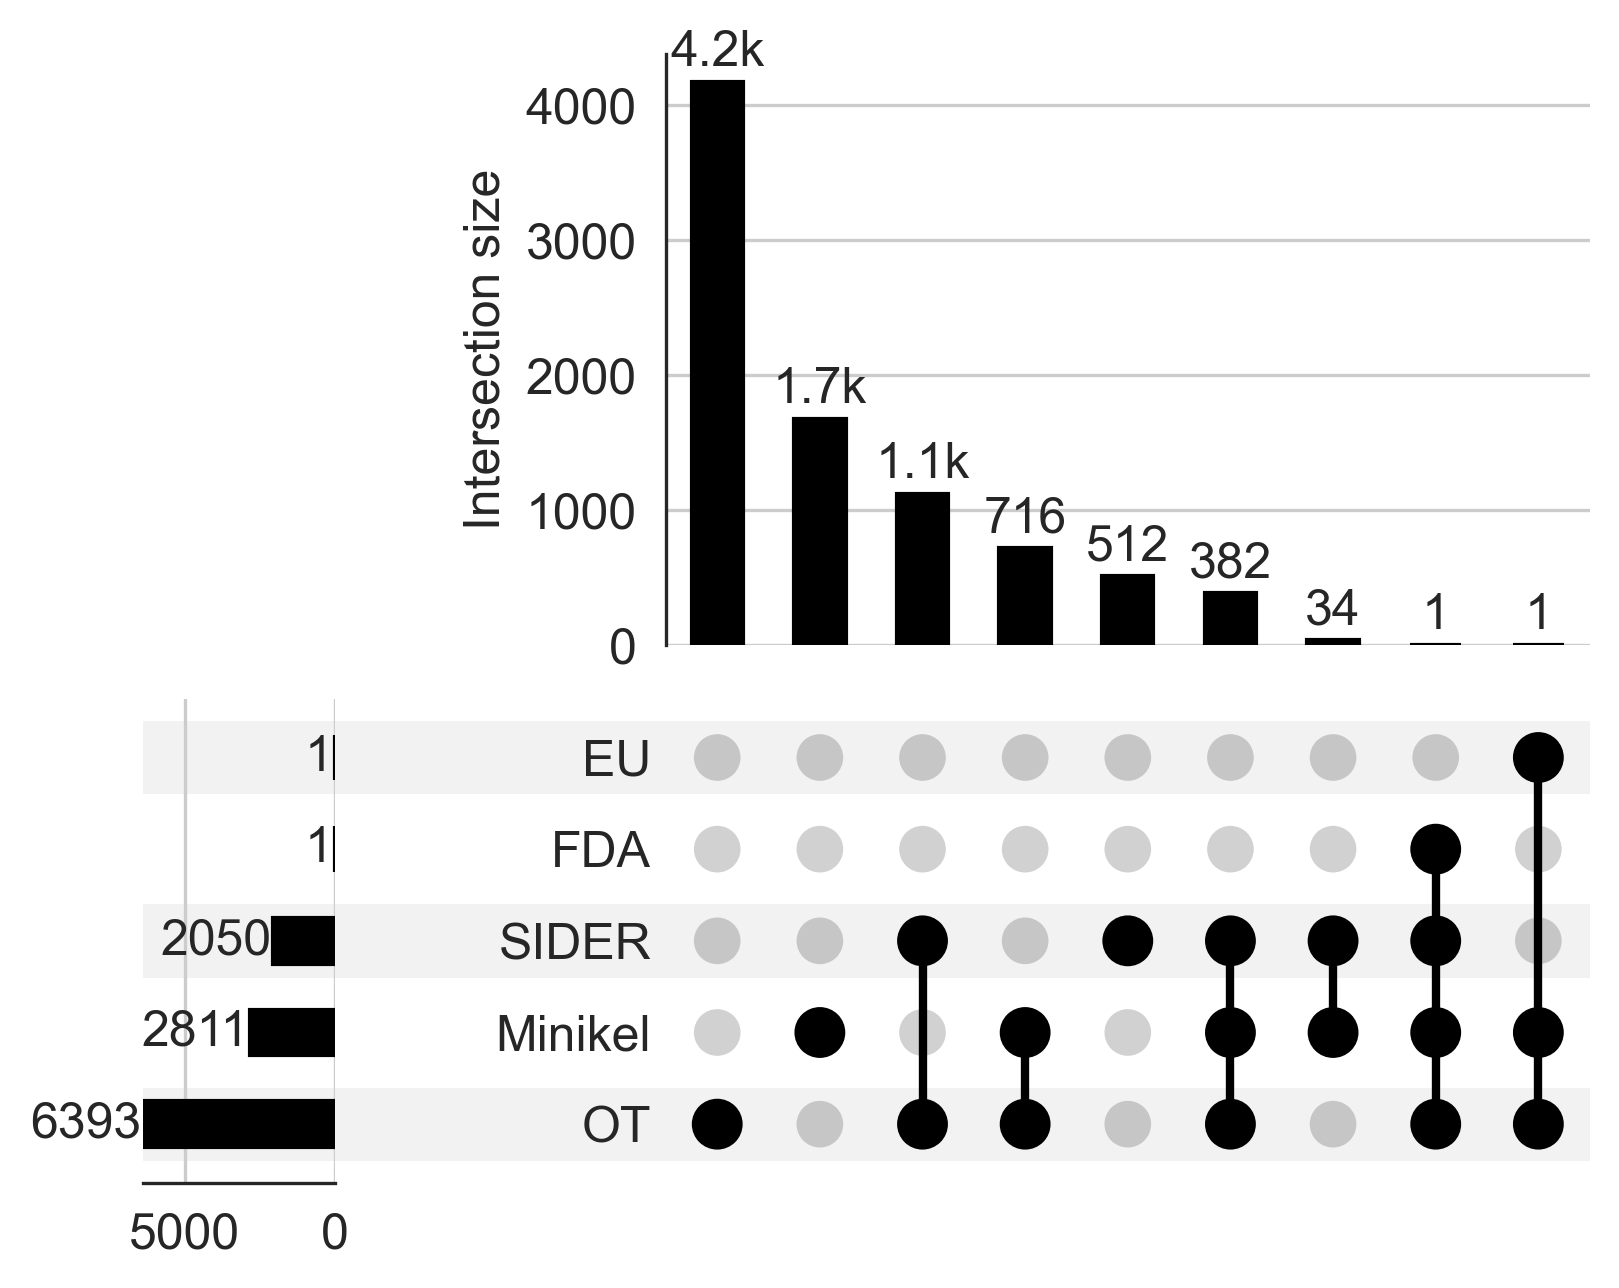

In [47]:
drugs = pd.read_pickle('./Final/drugs.pkl')
drugs = drugs.merge(rd[['phecode','Type']])
drugs = drugs.loc[drugs['Type'] == 'Common']

sources_dict = {source: drugs['source'].apply(lambda x: source in x) for source in ['OT','Minikel','FDA','SIDER','EU']}
drugs_upset = pd.DataFrame(sources_dict)
drugs_upset = drugs_upset.set_index(['OT', 'Minikel', 'FDA', 'EU','SIDER'])

fig = plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

upset = UpSet(drugs_upset, subset_size='count', min_subset_size=0, sort_by="cardinality", show_counts=True)
ax_dict = upset.plot(fig=fig)

for text in ax_dict['intersections'].texts:
    count = int(text.get_text())
    formatted_count = f'{count/1000:.1f}k' if count >= 1000 else str(count)
    text.set_text(formatted_count)


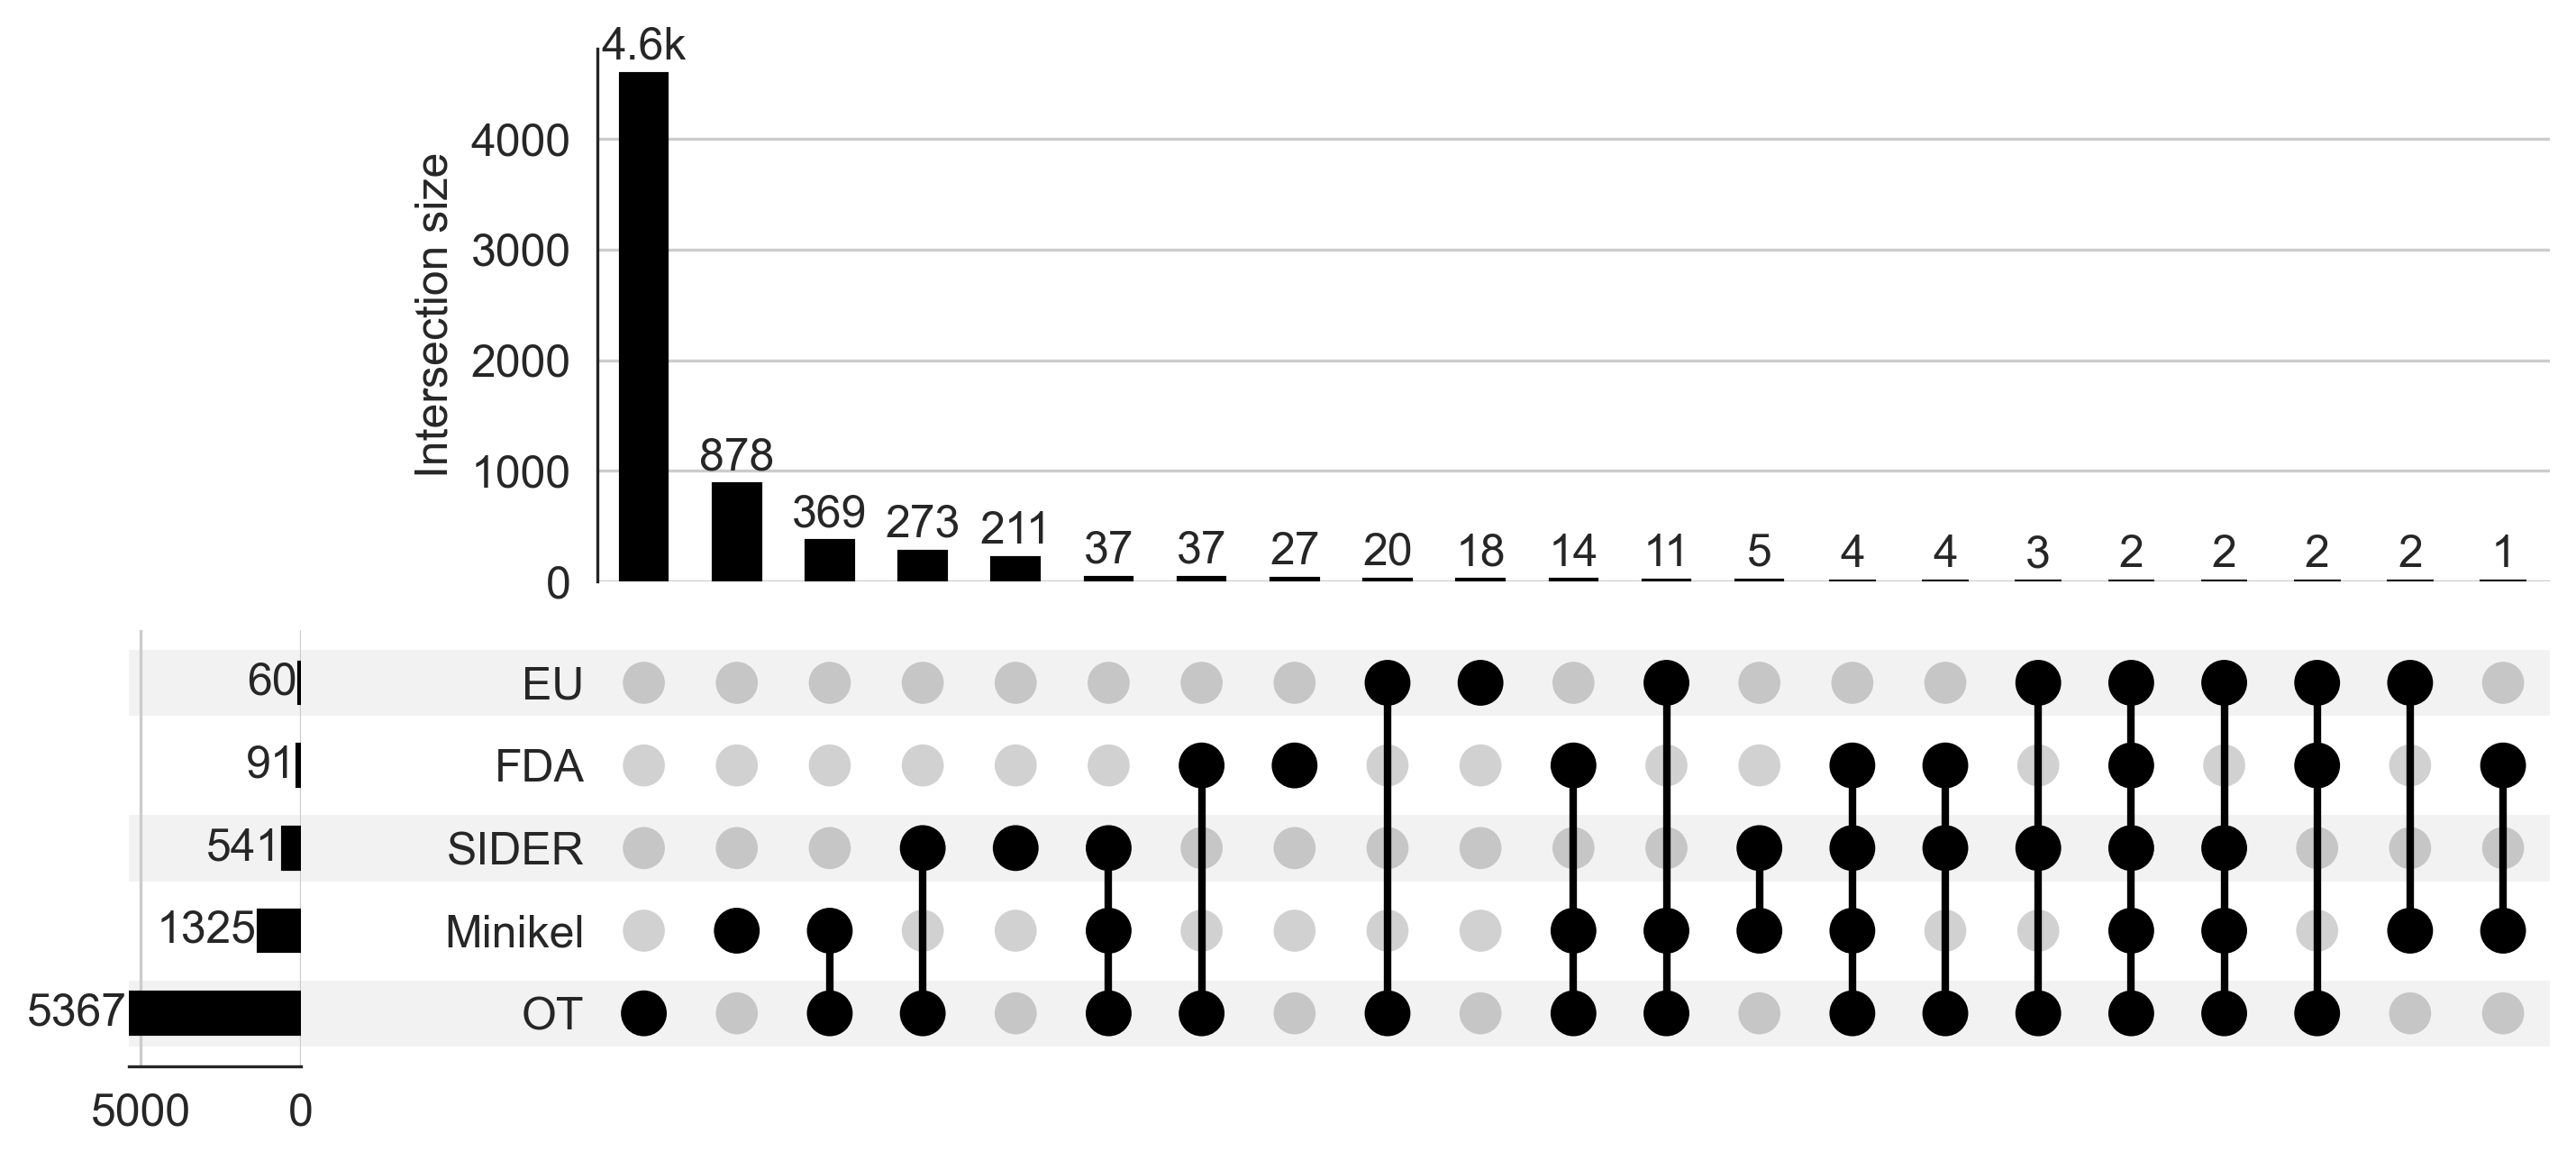

In [48]:
drugs = pd.read_pickle('./Final/drugs.pkl')
drugs = drugs.merge(rd[['phecode','Type']])
drugs = drugs.loc[drugs['Type'] == 'Rare']

sources_dict = {source: drugs['source'].apply(lambda x: source in x) for source in ['OT','Minikel','FDA','SIDER','EU']}
drugs_upset = pd.DataFrame(sources_dict)
drugs_upset = drugs_upset.set_index(['OT', 'Minikel', 'FDA', 'EU','SIDER'])

fig = plt.figure(figsize=(8, 4), dpi=300)
sns.set_style('white')

upset = UpSet(drugs_upset, subset_size='count', min_subset_size=0, sort_by="cardinality", show_counts=True)
ax_dict = upset.plot(fig=fig)

for text in ax_dict['intersections'].texts:
    count = int(text.get_text())
    formatted_count = f'{count/1000:.1f}k' if count >= 1000 else str(count)
    text.set_text(formatted_count)


## Data for 161 phecodes

In [7]:
drugs = pd.read_pickle('./Final/drugs.pkl')
md = pd.read_excel('./RareDrug/Resources/minikel_drugs.xlsx')
tg = pd.read_pickle('./Resources/targets.pkl')

ot_genes = pd.read_pickle('./OT/Raw/targets.pkl')
ot_genes = ot_genes.loc[~ot_genes['approvedSymbol'].str.contains('ENSG')]
ot_genes = ot_genes.loc[ot_genes['biotype'] == 'protein_coding']
ot_genes = ot_genes['approvedSymbol'].to_list()
ot_genes = list(set(drugs['gene'].to_list() + ot_genes))

combinations = list(itertools.product(ot_genes, rd['phecode'].unique()))
df = pd.DataFrame(combinations, columns=['gene', 'phecode'])
df['drug_gene'] = 0
df.loc[df['gene'].isin(drugs['gene']), 'drug_gene'] = 1
df.loc[df['gene'].isin(md['target']), 'drug_gene'] = 1
df.loc[df['gene'].isin(tg['gene']), 'drug_gene'] = 1
df = df.merge(drugs, on=['gene','phecode'], how='left')
df['phase'] = df['phase'].fillna(0)
df['indication'] = 0
df.loc[df['phase'] > 0, 'indication'] = 1
df.to_pickle('./Final/gene_phecode_pairs.pkl')

drugs = 0
ot_genes = 0

In [3]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7497289/

def normalized_harmonic_sum(x):
    x_sorted = np.sort(x)[::-1]
    harmonic_sum = np.sum(x_sorted / (np.arange(1, len(x_sorted) + 1) ** 2))
    max_harmonic_sum = 1.644  # Given approximation for a vector of 1,000 ones
    return harmonic_sum / max_harmonic_sum

df = pd.read_pickle('./Final/gene_phecode_pairs.pkl')[['gene','phecode']]

ge = pd.read_pickle('./OT/Final/hgmd.pkl')
ge['score'] = ge['CLASS'].map({'DM':0.9,'DM?':0.7,'DFP':0.5,'DP':0.3,'FP':0.1})
ge = ge.groupby(['ID','phecode','GENE'])['score'].max().reset_index().rename({'GENE':'gene'},axis=1)
ge = ge.loc[ge['phecode'].isin(rd['phecode'])]
ge['datasourceId'] = 'hgmd'
ge = pd.pivot_table(ge, index=['phecode','gene'], columns='datasourceId', values='score', aggfunc=normalized_harmonic_sum).reset_index()
df = df.merge(ge, on=['phecode','gene'], how='left')

omim = pd.read_pickle('./OT/Final/omim.pkl').rename({'Gene':'gene'},axis=1)
omim['omim'] = 1
df = df.merge(omim, on=['phecode','gene'], how='left')

dbs = pd.read_pickle('./OT/Precalculated/direct_by_source.pkl')
df = df.merge(dbs, on=['phecode','gene'], how='left')

df = df.dropna(thresh=3)
df = df.dropna(how='all', axis=1)
df.to_pickle('./Final/OT_evidence.pkl')


In [9]:
hpo = pd.read_csv('./Resources/hpo_terms.tsv', sep='\t')
hpo = hpo[['hpo_code','hpo_label']].set_axis(['code','disease'],axis=1)
hpo['disease'] = hpo['disease'].str.lower()

map = pd.read_pickle('./OT/Final/diseases_cleaned.pkl')
map['code'] = map['code'].astype(str)
hp_map = map.loc[map['terminology'] == 'HP'][['code','id']]
phecode_map = map.loc[map['phecode'].notna()][['id','phecode']]
hp_map = hp_map.merge(phecode_map)
hp_map = hp_map[['code','phecode']]
hp_map['code'] = 'HP_' + hp_map['code']

hp = pd.read_pickle('./OT/HPO/hpo_phecodex_map.pkl')[['phecode','id']]
hp = hp.rename({'id':'code'},axis=1)
hp = hp[['code','phecode']]

hp_map = pd.concat([hp, hp_map]).drop_duplicates()
hpo = hpo.merge(hp_map)

mantis = pd.read_csv('./Resources/MANTIS/mantis_ml_scores_out-release.tsv', sep='\t')
mantis['disease'] = mantis['disease'].str.lower()
mantis = mantis.merge(hpo).drop(['resource','disease'],axis=1)
mantis = pd.melt(mantis, id_vars=['code','phecode'])
mantis = mantis.sort_values('value', ascending=False).drop_duplicates(['phecode','variable'])
mantis = mantis[['phecode','variable','value']].set_axis(['phecode','gene','mantis'],axis=1)
mantis.to_pickle('./Final/mantis.pkl')


In [10]:
ot_genes = pd.read_pickle('./OT/Raw/targets.pkl')
ot_genes = ot_genes.loc[~ot_genes['approvedSymbol'].str.contains('ENSG')]
ot_genes = ot_genes.loc[ot_genes['biotype'] == 'protein_coding']

gnomad = pd.read_csv('./Resources/gnomad.v4.1.constraint_metrics.tsv', sep='\t')
gnomad = gnomad.loc[gnomad['canonical'] == True]
gnomad = gnomad.loc[gnomad['gene_id'].isin(ot_genes['id'])].sort_values('mane_select',ascending=False).drop_duplicates('gene_id')
gnomad = gnomad[['gene_id','lof.oe_ci.upper']].set_axis(['id','loeuf'],axis=1)
gnomad = gnomad.merge(ot_genes[['id','approvedSymbol']]).rename({'approvedSymbol':'gene'},axis=1)
gnomad = gnomad.drop('id',axis=1)
gnomad.to_pickle('./Final/gnomad.pkl')


In [11]:
df = pd.read_pickle('./Final/gene_phecode_pairs.pkl')[['gene','phecode']]

df['phecode_type'] = 'Rare'
df.loc[df['phecode'].isin(cd['phecode']), 'phecode_type'] = 'Common'
df = df.merge(rd[['phecode','prop_all']], on='phecode').rename({'prop_all':'case_proportion'},axis=1)

cov = rd[['phecode']].copy()
cov['phecode_category'] = cov['phecode'].str.split('_').str[0]
df = df.merge(cov, on='phecode')
df['phecode_category'] = pd.Categorical(df['phecode_category'])

gnomad = pd.read_pickle('./Final/gnomad.pkl').drop_duplicates('gene')
df = df.merge(gnomad, on='gene', how='left')

dg = pd.read_csv('./Resources/drugnome.csv').rename({'Gene Name':'gene'},axis=1)[['gene','Tclin']].drop_duplicates('gene')
df = df.merge(dg, on='gene', how='left') 
    
ld = pd.read_csv('./RareDisease/Genetics/Common/LDSC.csv')
ld = ld[['phecode','h2_1']].set_axis(['phecode','cc_h2'],axis=1).drop_duplicates('phecode')
df = df.merge(ld, on='phecode', how='left')

df.to_pickle('./Final/covariates.pkl')


In [3]:
c = pd.read_pickle('./RareDisease/DrugInput/common.pkl').rename({'Gene':'gene','Phecode':'phecode'},axis=1)
r = pd.read_pickle('./RareDisease/DrugInput/rare.pkl').rename({'Gene':'gene','Phecode':'phecode'},axis=1)
rb = pd.read_pickle('./RareDisease/DrugInput/rare_burden.pkl').rename({'Gene':'gene','Phecode':'phecode'},axis=1)
ur = pd.read_pickle('./RareDisease/DrugInput/ultrarare.pkl').rename({'Gene':'gene','Phecode':'phecode'},axis=1)

ga = c.merge(r, on=['gene','phecode'], how='outer')\
    .merge(rb, on=['gene','phecode'], how='outer')\
    .merge(ur, on=['gene','phecode'], how='outer')
ga = ga.groupby(['gene','phecode']).max().reset_index()
ga.to_pickle('./Final/genetic_associations.pkl')


In [3]:
df = pd.read_pickle('./Final/gene_phecode_pairs.pkl')
df['id'] = df['phecode'] + ':' + df['gene']

ot = pd.read_pickle('./Final/OT_evidence.pkl')
cov = pd.read_pickle('./Final/covariates.pkl')
ga = pd.read_pickle('./Final/genetic_associations.pkl')
ga = ga.loc[ga['gene'].isin(df['gene'])]
mantis = pd.read_pickle('./Final/mantis.pkl')

ot = ot.merge(ga, on=['gene','phecode'], how='outer')
ot = ot.dropna(thresh=3)
df = df.loc[(df['drug_gene'] == 1) | (df['indication'] == 1) | (df['gene'].isin(ot['gene']))]
df = df.merge(ot, on=['gene','phecode'], how='left')
df = df.merge(mantis, on=['gene','phecode'], how='left')

for col in ['clingen', 'eva', 'gene2phenotype', 'gene_burden', 'genomics_england', 'orphanet', 'ot_genetics_portal',
            'uniprot_literature', 'uniprot_variants', 'hgmd', 'omim', 'cancer_gene_census', 'eva_somatic',
            'reactome', 'sysbio', 'chembl', 'europepmc', 'expression_atlas', 'impc',
            'drug_gene','phase','n_drugs','indication']: # 'intogen', 'crispr', 'slapenrich', 'cancer_biomarkers'
    df[col] = df[col].fillna(0)

for col in ['cc_common_max_p',
            'cc_rare_max_p',
            'cc_rare_burden_max_p',
            'cc_ultrarare_max_p']:
    df[col] = df[col].round(5)

df = df.merge(cov, on=['gene','phecode'])

# df.loc[(df['indication'] == 1) & (df['chembl'] == 0), 'chembl'] = 0.05/1.644 # FDA/EU --> indication = min/1.644

#####

def harmonic_sum(row):
    scores = row.sort_values(ascending=False).values
    positional_ids = np.arange(1, len(scores) + 1)
    harmonic_sum = np.sum(scores / (positional_ids ** 2))
    max_harmonic_sum = np.sum(1 / (positional_ids ** 2))
    normalized_sum = harmonic_sum / max_harmonic_sum
    return normalized_sum

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_variants','uniprot_literature']
temp = df.loc[df[clin + ['phase']].sum(axis=1) > 0] 
temp['clin_ot'] = temp[clin].apply(harmonic_sum, axis=1)
if False:
    temp['drug_score'] = 1
    temp.loc[temp['phase'] == 3, 'drug_score'] = 1*0.580
    temp.loc[temp['phase'] == 2, 'drug_score'] = 1*0.580*0.548
    temp.loc[temp['phase'] <= 1, 'drug_score'] = 1*0.580*0.548*0.732
    temp['dgs'] = temp[['drug_score','clin_ot']].apply(harmonic_sum, axis=1)
temp = temp[['gene','phecode','clin_ot']]
df = df.merge(temp, how='left')
df['clin_ot'] = df['clin_ot'].fillna(0)

#####

df.to_pickle('./Final/drugs_ot.pkl')


In [40]:
def harmonic_sum(row):
    scores = row.sort_values(ascending=False).values
    positional_ids = np.arange(1, len(scores) + 1)
    harmonic_sum = np.sum(scores / (positional_ids ** 2))
    max_harmonic_sum = np.sum(1 / (positional_ids ** 2))
    normalized_sum = harmonic_sum / max_harmonic_sum
    return normalized_sum

df = pd.read_pickle('./Final/drugs_ot.pkl')
df = df.loc[df['phecode_type'] == 'Rare'].drop(['phecode_type'],axis=1)
df = df.sample(frac=1, random_state=42)
df['loeuf'] = df['loeuf'].round(1)
df.to_pickle('./Final/ml_input.pkl')
